# Folk Songs

In [ ]:
import pandas as pd
import music21 as m21
import numpy as np
import statsmodels.api as sm

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc_context(rc=None, fname="../matplotlibrc");

In [2]:
# parse all
corpora = m21.corpus.getComposer('essenFolksong')

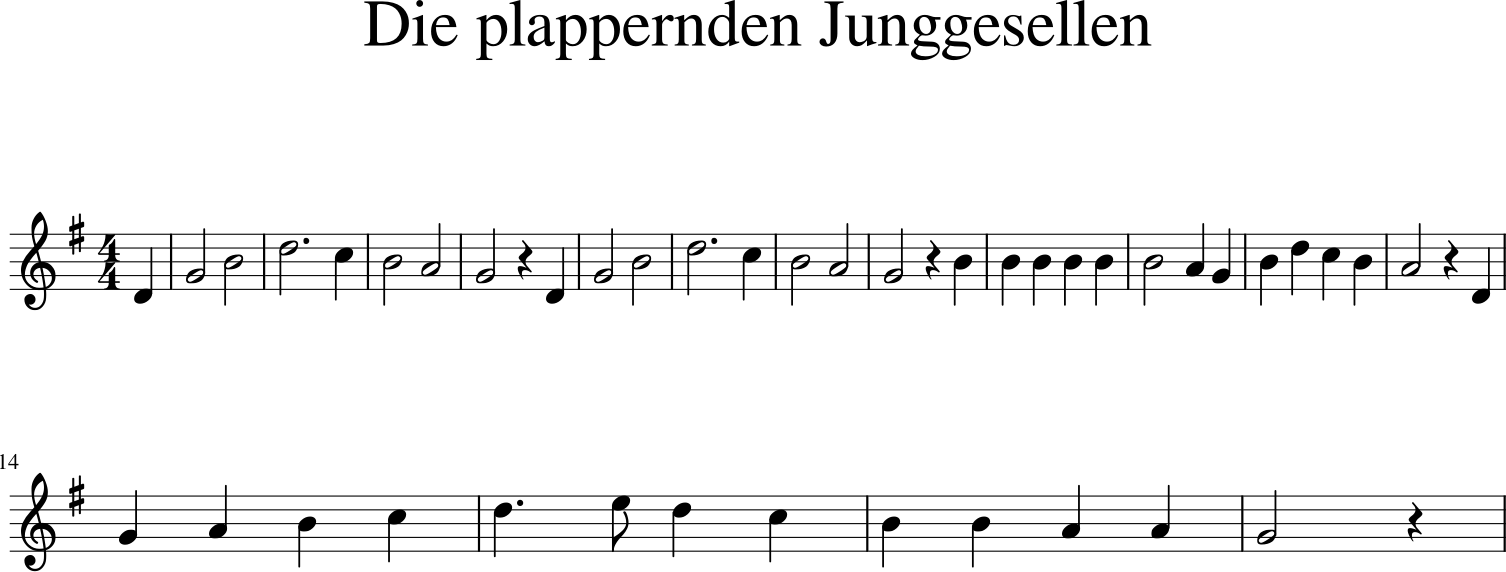

In [55]:
german_song = m21.converter.parse(corpora[0])[70]
german_song.show(fmt="musicxml.png", fp="./img/german_song.png")
german_song.show()

In [56]:
german_song.show("mid")

In [57]:
%%time 

# takes about 5 mins

songs = [s for i in range(len(corpora)) for s in m21.converter.parse(corpora[i]) ]

Wall time: 57.5 s


In [58]:
len(songs)

8514

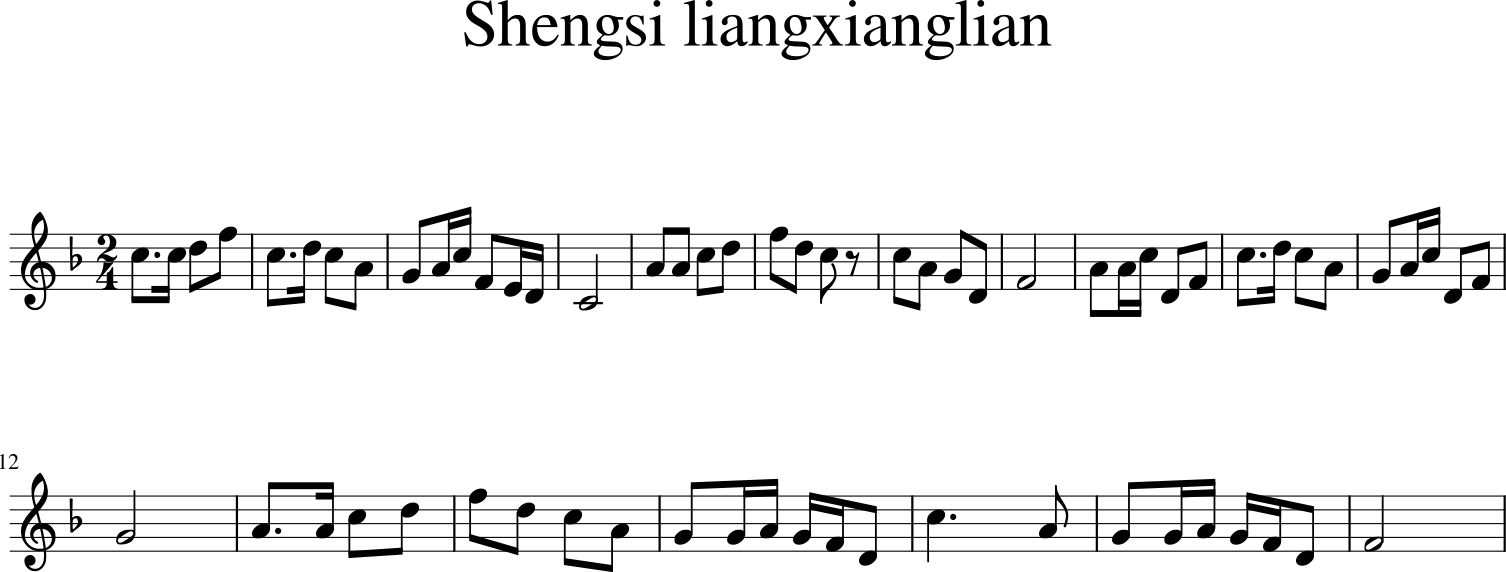

In [62]:
chinese_song = songs[6200]
chinese_song.show(fmt="musicxml.png", fp="./img/chinese_song.png")
chinese_song.show()

In [63]:
chinese_song.show("mid")

In [65]:
[(note.pitch.midi, note.quarterLength/4) for note in chinese_song.flat.notes][:10]

[(72, 0.1875),
 (72, 0.0625),
 (74, 0.125),
 (77, 0.125),
 (72, 0.1875),
 (74, 0.0625),
 (72, 0.125),
 (69, 0.125),
 (67, 0.125),
 (69, 0.0625)]

In [66]:
dfs = []

for i in range(len(songs)):
    df = pd.DataFrame( [(i, note.pitch.midi, note.quarterLength/4) for note in songs[i].flat.notes ], columns=["song_id", "pitch", "duration"])
    df["onset"] = df["duration"].cumsum()
    df["rel_onset"] = df["onset"] / df["onset"].max()
    df["Z_pitch"] = (df["pitch"] - df["pitch"].mean())/df["pitch"].std(ddof=0)
    
    dfs.append(df)

big_df = pd.concat(dfs).reset_index(drop=True)
big_df.to_csv("data/big_df.csv")
big_df.shape

(450596, 6)

In [15]:
big_df.head(10)

,piece_id,pitch,duration,onset,rel_onset,Z_pitch
0,0,67,0.5,0.5,0.013158,-1.834390
1,0,70,0.5,1.0,0.026316,-0.748238
2,0,71,0.5,1.5,0.039474,-0.386187
3,0,72,0.5,2.0,0.052632,-0.024137
4,0,72,0.5,2.5,0.065789,-0.024137
5,0,74,1.0,3.5,0.092105,0.699965
6,0,74,1.0,4.5,0.118421,0.699965
7,0,74,1.0,5.5,0.144737,0.699965
8,0,74,0.5,6.0,0.157895,0.699965
9,0,74,0.5,6.5,0.171053,0.699965


In [16]:
big_df.tail()

,piece_id,pitch,duration,onset,rel_onset,Z_pitch
450591,8513,71,0.0625,7.1250,0.934426,0.696113
450592,8513,69,0.0625,7.1875,0.942623,0.099445
450593,8513,73,0.0625,7.2500,0.950820,1.292781
450594,8513,71,0.2500,7.5000,0.983607,0.696113
450595,8513,69,0.1250,7.6250,1.000000,0.099445


In [17]:
big_df.sample(5)

,piece_id,pitch,duration,onset,rel_onset,Z_pitch
84723,1952,62,0.250,3.000,0.206897,-2.068852
208027,4441,67,0.375,0.625,0.086207,-0.850686
114121,2463,62,0.375,10.375,0.576389,0.879004
222508,4724,72,0.250,20.500,0.881720,0.771902
352331,6615,67,0.250,4.000,0.266667,0.635128


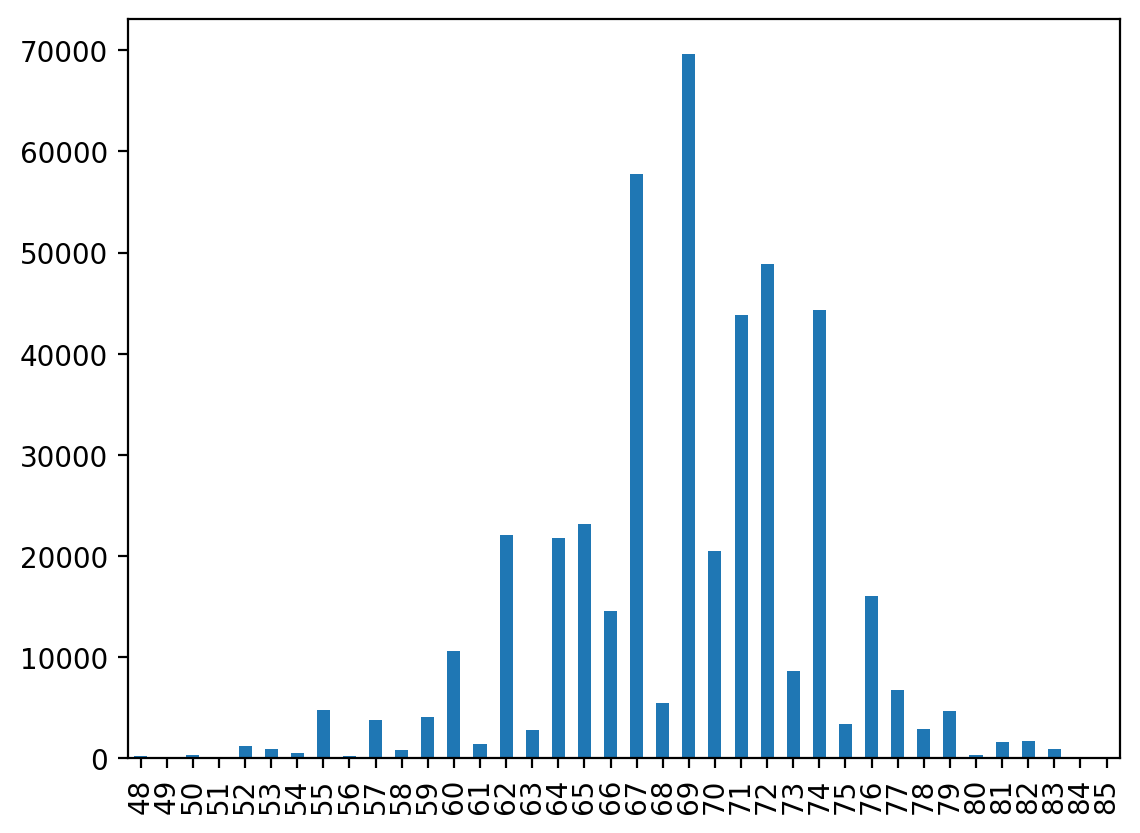

In [18]:
big_df["pitch"].value_counts().sort_index().plot(kind="bar");

In [19]:
# FIRST concat dfs and THEN create new cols

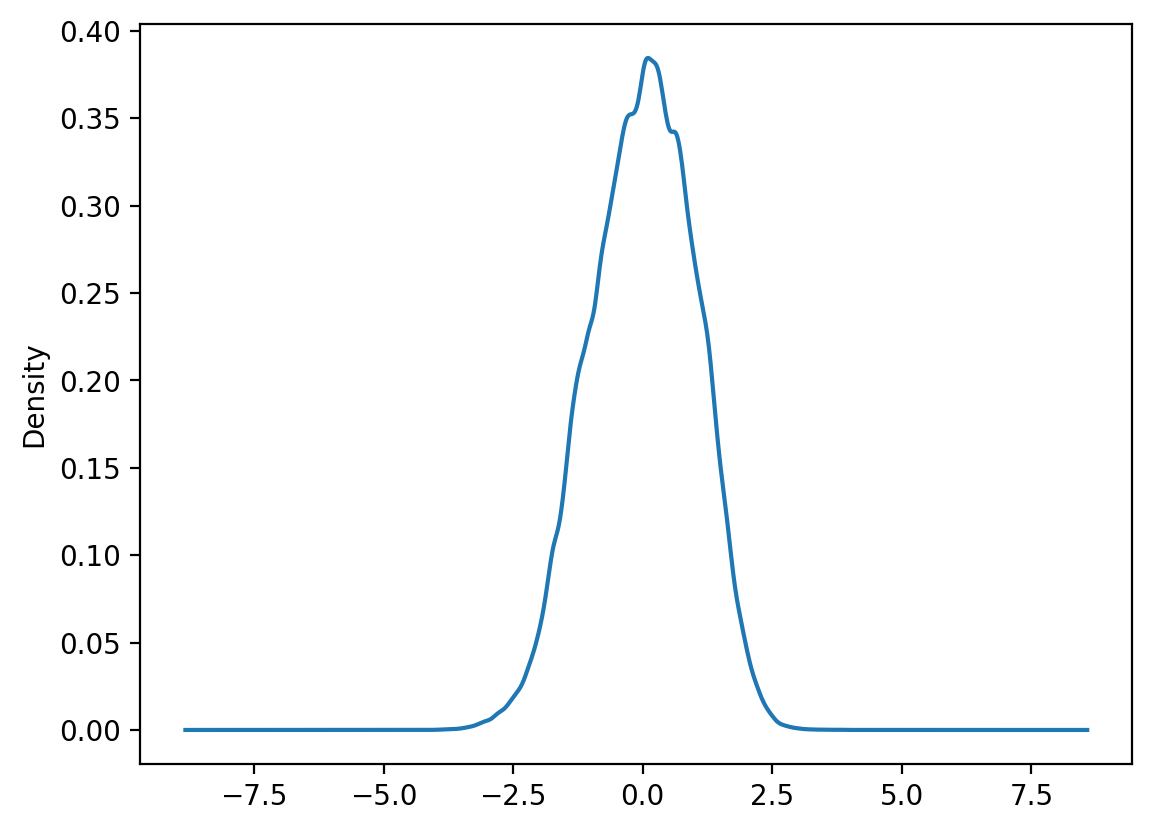

In [20]:
big_df["Z_pitch"].plot(kind="kde");

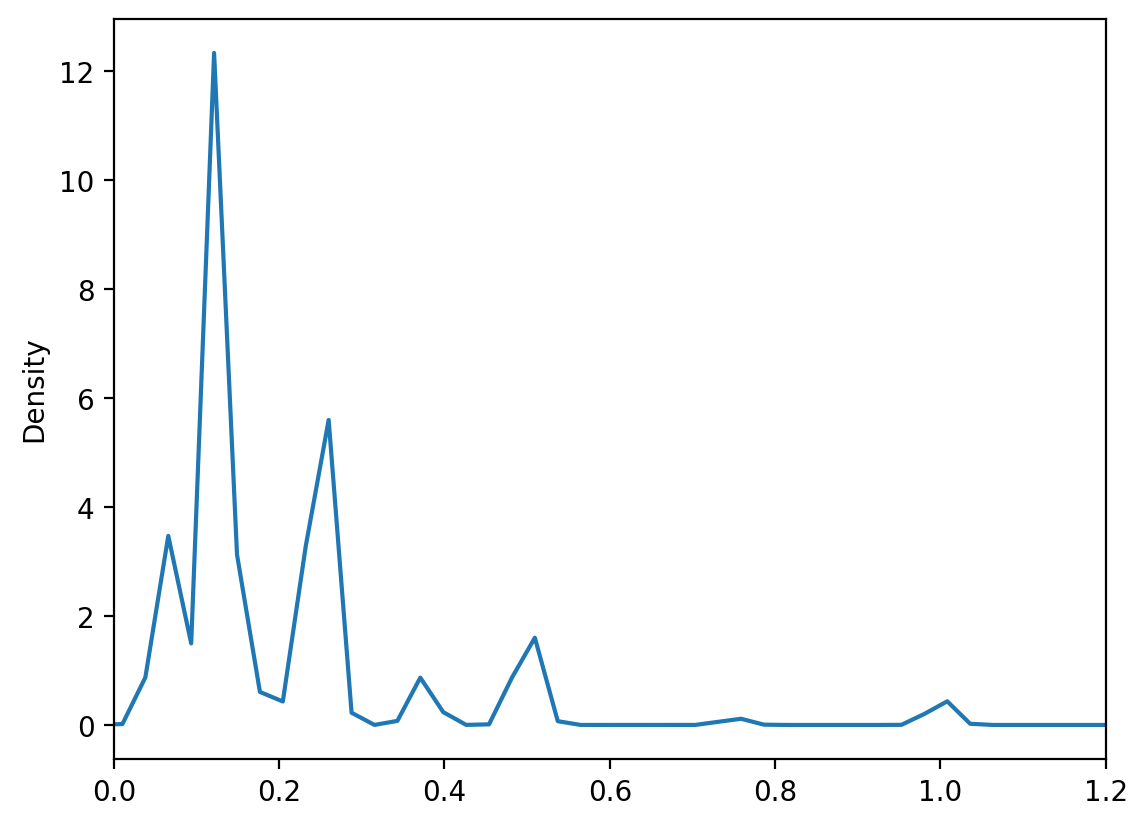

In [21]:
big_df["duration"].plot(kind="kde",xlim=(0,1.2));

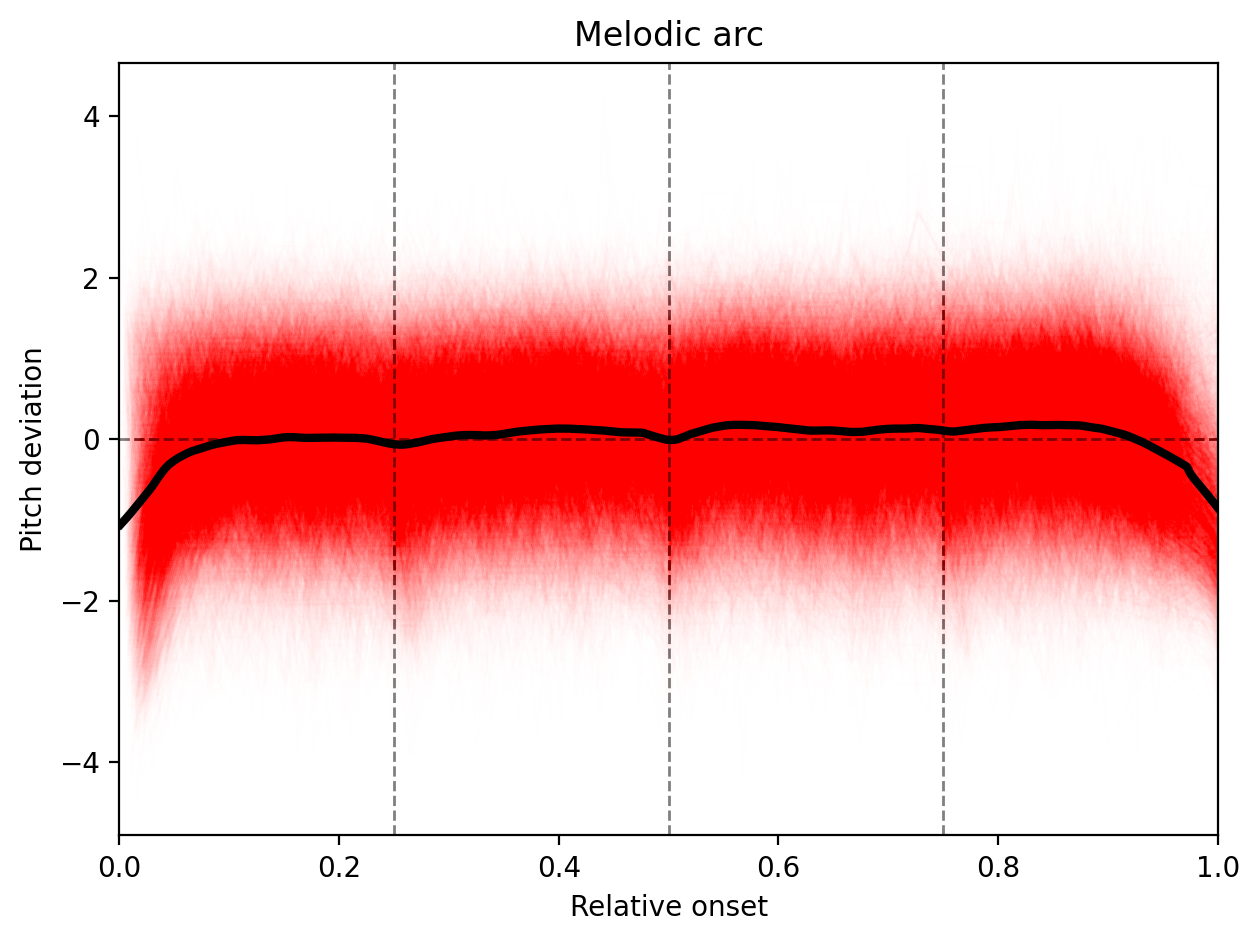

In [30]:
fig, ax = plt.subplots()
plt.xlim(0,1)

ax.axvline(.25, lw=1, ls="--", c="gray")
ax.axvline(.5, lw=1, ls="--", c="gray")
ax.axvline(.75, lw=1, ls="--", c="gray")
ax.axhline(0, lw=1, ls="--", c="gray")

grouped = big_df.groupby("piece_id")

for i, g in grouped:
        x = g["rel_onset"].values
        y = g["Z_pitch"].values
        ax.plot(x,y, c="red", lw=1, alpha=0.0025)

lowess = sm.nonparametric.lowess
big_x = big_df["rel_onset"].values
big_y = big_df["Z_pitch"].values
big_z = lowess(big_y, big_x, frac=5/100)
ax.plot(big_z[:,0], big_z[:,1], c="black", lw=3)

plt.title("Melodic arc")
plt.xlabel("Relative onset")
plt.ylabel("Pitch deviation")

plt.tight_layout()
plt.savefig("img/melodic_arc.png", dpi=300)
plt.show()